In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.special import inv_boxcox
from prophet import Prophet  # For Prophet v1.0+: use `from prophet import Prophet`
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import math


c:\Users\Uttam Kumar\Learning\Time-series\codebase\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# ----------------------
# 1. Data Preparation & Feature Engineering
# ----------------------
def apply_boxcox(series, provided_lambda=None):
    """
    Apply a Box-Cox transformation for variance stabilization.
    If provided_lambda is given, use it instead of estimating.
    Returns transformed series and the lambda used.
    """
    if provided_lambda is None:
        transformed, lambda_val = st.boxcox(series)
    else:
        transformed = st.boxcox(series, lmbda=provided_lambda)
        lambda_val = provided_lambda
    return transformed, lambda_val

In [11]:
def engineer_features_refined(df, target_col='cpu_used'):
    """
    Engineer additional features:
      - lag1, lag2, lag3: previous day values
      - rolling_mean_7 and rolling_median_7: 7-day rolling average and median (shifted)
      - Cyclical features for day-of-week and month.
    Assumes DataFrame index is datetime.
    """
    df = df.copy()
    # Create required date column for Prophet
    df['ds'] = df.index
    
    # Add lag features
    df['lag1'] = df[target_col].shift(1)
    df['lag2'] = df[target_col].shift(2)
    df['lag3'] = df[target_col].shift(3)
    
    # Add rolling features (mean and median) with a 7-day window (shifted so that current day is not used)
    df['rolling_mean_7'] = df[target_col].rolling(window=7).mean().shift(1)
    df['rolling_median_7'] = df[target_col].rolling(window=7).median().shift(1)
    
    # Cyclical features for day-of-week (Monday=0, Sunday=6)
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['day_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
    
    # Cyclical features for month (1-12)
    df['month'] = df['ds'].dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Drop rows with NA due to shifting and rolling
    df = df.dropna()
    return df

In [12]:
def prepare_prophet_data(df, target_col='cpu_used', boxcox_lambda=None):
    """
    Prepare the data for Prophet:
      - Apply Box-Cox transformation to the target variable.
      - Engineer refined extra features.
    Returns DataFrame for Prophet (with required columns) and the lambda value.
    """
    df = df.copy()
    
    # Apply Box-Cox transformation on target
    transformed, lambda_val = apply_boxcox(df[target_col], provided_lambda=boxcox_lambda)
    df['y_boxcox'] = transformed

    # Engineer extra regressors on the original target (alternatively, one might also transform these)
    df_feat = engineer_features_refined(df, target_col=target_col)
    # Use the Box-Cox transformed value as the target for Prophet
    df_feat['y'] = df_feat['y_boxcox']
    
    # Select columns required by Prophet:
    cols = ['ds', 'y', 'lag1', 'lag2', 'lag3', 'rolling_mean_7', 'rolling_median_7',
            'day_sin', 'day_cos', 'month_sin', 'month_cos']
    df_prophet = df_feat[cols].reset_index(drop=True)
    return df_prophet, lambda_val

In [22]:
# ----------------------
# 2. Prophet Model with Extra Regressors
# ----------------------
def train_prophet_model(df_prophet, extra_regressor_cols,
                        changepoint_prior_scale=0.5,
                        seasonality_prior_scale=10):
    """
    Build and fit a Prophet model with extra regressors and tuned hyperparameters.
    Here, we increase changepoint_prior_scale to allow more flexibility,
    and seasonality_prior_scale to let the model capture seasonal variation.
    """
    # Turn off default seasonalities as we are adding our features
    model = Prophet(daily_seasonality=False,
                    weekly_seasonality=True,
                    yearly_seasonality=False,
                    changepoint_prior_scale=changepoint_prior_scale,
                    seasonality_prior_scale=seasonality_prior_scale,
                    seasonality_mode='additive',
                    interval_width=0.95,
                    changepoint_range=0.8)
    # Add each extra regressor
    for col in extra_regressor_cols:
        model.add_regressor(col)
    
    # Fit the model
    model.fit(df_prophet)
    return model

In [15]:
def predict_full_horizon(model, df_prophet):
    """
    Use the fitted Prophet model to predict on the entire horizon (same dates as df_prophet).
    
    Returns:
       forecast: Prophet's forecast DataFrame including yhat.
    """
    forecast = model.predict(df_prophet)
    return forecast

In [7]:
# ----------------------
# 3. Evaluation
# ----------------------

def evaluate_forecast(df_prophet, forecast, lambda_val):
    """
    Invert the Box-Cox transformation and calculate MAE and MAPE between the actual and forecasted values.
    
    Args:
       df_prophet (DataFrame): Data used for training (with column y in Box-Cox space).
       forecast (DataFrame): Predictions from Prophet (column 'yhat', in Box-Cox space).
       lambda_val (float): The lambda parameter for Box-Cox; used to invert the transform.
       
    Returns:
       mae, mape, actual_orig, predicted_orig: evaluation metrics and original-scale series.
    """
    # Invert the transformation from the Box-Cox scale back to original scale
    predicted_orig = inv_boxcox(forecast['yhat'], lambda_val)
    actual_orig = inv_boxcox(df_prophet['y'], lambda_val)
    
    mae = mean_absolute_error(actual_orig, predicted_orig)
    mape = mean_absolute_percentage_error(actual_orig, predicted_orig) * 100
    return mae, mape, actual_orig, predicted_orig

In [23]:
# --------------------------
# Step 4. Full Pipeline for Prophet Forecasting per Namespace
# --------------------------
def run_prophet_forecast(df, target_col='cpu_used', boxcox_lambda=None):
    """
    Execute the full pipeline:
      1. Prepare the data (apply Box-Cox and refine feature engineering).
      2. Train a Prophet model (with tuned hyperparameters) using extra regressors.
      3. Forecast on the full horizon and invert the transformation.
      4. Evaluate using MAE and MAPE.
      
    Returns:
       df_prophet: DataFrame used for Prophet training.
       forecast: Forecasted values (includes yhat).
       lambda_val: Box-Cox lambda.
       mae, mape: Evaluation metrics (on original scale).
       model: The fitted Prophet model.
    """
    df = df.sort_index()
    df_prophet, lambda_val = prepare_prophet_data(df, target_col=target_col, boxcox_lambda=boxcox_lambda)
    
    # List all extra regressors engineered
    extra_cols = ['lag1', 'lag2', 'lag3', 
                  'rolling_mean_7', 'rolling_median_7',
                  'day_sin', 'day_cos', 'month_sin', 'month_cos']
    
    # We tune Prophet hyperparameters for more flexibility:
    # Increase changepoint_prior_scale to allow faster adaptation (default=0.05)
    # Increase seasonality_prior_scale to allow stronger seasonal changes.
    model = train_prophet_model(df_prophet, extra_cols,
                                changepoint_prior_scale=0.5,
                                seasonality_prior_scale=11)
    
    # In-sample prediction on the full horizon
    forecast = predict_full_horizon(model, df_prophet)
    
    # Evaluate the predictions on the original scale.
    mae, mape, actual_orig, predicted_orig = evaluate_forecast(df_prophet, forecast, lambda_val)
    return df_prophet, forecast, lambda_val, mae, mape, model, actual_orig, predicted_orig

01:02:39 - cmdstanpy - INFO - Chain [1] start processing


Processing namespace: alpha


01:02:39 - cmdstanpy - INFO - Chain [1] done processing


Namespace: alpha -- MAE: 8.3874, MAPE: 48.23%



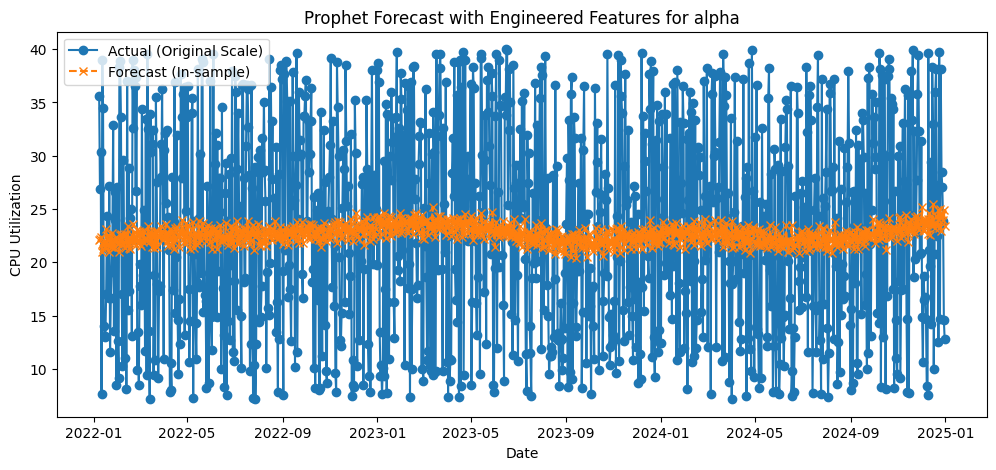

01:02:40 - cmdstanpy - INFO - Chain [1] start processing


Processing namespace: beta


01:02:40 - cmdstanpy - INFO - Chain [1] done processing


Namespace: beta -- MAE: 8.1940, MAPE: 47.32%



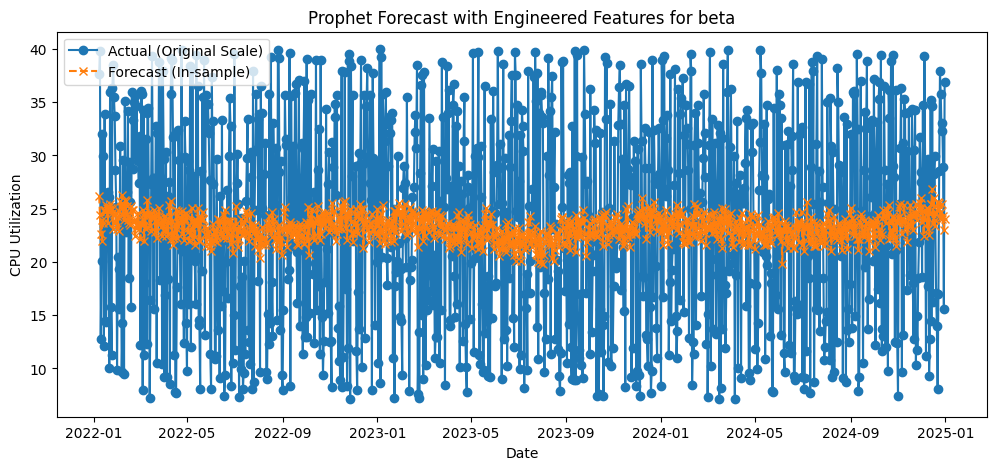

01:02:41 - cmdstanpy - INFO - Chain [1] start processing


Processing namespace: gamma


01:02:41 - cmdstanpy - INFO - Chain [1] done processing


Namespace: gamma -- MAE: 8.1530, MAPE: 47.60%



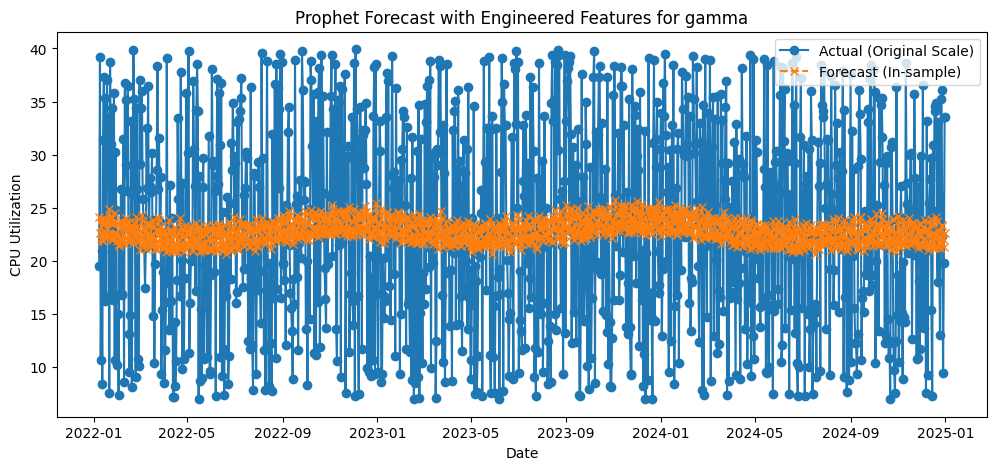

Namespace: alpha -- MAE: 8.3874, MAPE: 48.23%
Namespace: beta -- MAE: 8.1940, MAPE: 47.32%
Namespace: gamma -- MAE: 8.1530, MAPE: 47.60%


In [24]:
# ----------------------
# 5. Example Usage (for a given namespace)
# ----------------------
if __name__ == '__main__':
    # Read the data from CSV. Expecting columns: date, namespace, cpu_used
    df = pd.read_csv("../data/cpu_usage_test.csv", parse_dates=["date"])
    df.set_index("date", inplace=True)
    
    # Process each namespace separately
    namespaces = df["namespace"].unique()
    results = {}
    for ns in namespaces:
        print("==========================================")
        print(f"Processing namespace: {ns}")
        df_ns = df[df["namespace"] == ns]
        try:
            (df_prophet, forecast, lambda_val, mae, mape, model, 
             actual_orig, predicted_orig) = run_prophet_forecast(df_ns, target_col='cpu_used')
        except Exception as e:
            print(f"Error processing namespace {ns}: {e}")
            continue
        
        print(f"Namespace: {ns} -- MAE: {mae:.4f}, MAPE: {mape:.2f}%\n")
        results[ns] = {
            "df_prophet": df_prophet,
            "forecast": forecast,
            "lambda": lambda_val,
            "mae": mae,
            "mape": mape,
            "model": model,
            "actual": actual_orig,
            "predicted": predicted_orig
        }
        
        # Plot actual vs predicted (on original scale)
        plt.figure(figsize=(12, 5))
        plt.plot(df_prophet['ds'], actual_orig, label="Actual (Original Scale)", marker='o', linestyle='-')
        plt.plot(df_prophet['ds'], predicted_orig, label="Forecast (In-sample)", marker='x', linestyle='--')
        plt.title(f"Prophet Forecast with Engineered Features for {ns}")
        plt.xlabel("Date")
        plt.ylabel("CPU Utilization")
        plt.legend()
        plt.show()
    
    # Summary across namespaces:
    for ns, res in results.items():
        print(f"Namespace: {ns} -- MAE: {res['mae']:.4f}, MAPE: {res['mape']:.2f}%")

Processing namespace: alpha
SARIMAX selected order: (0, 0, 0) seasonal order: (0, 0, 0, 7)


01:21:32 - cmdstanpy - INFO - Chain [1] start processing
01:21:32 - cmdstanpy - INFO - Chain [1] done processing


Namespace: alpha -> MAE: 8.6917, MAPE: 49.67%


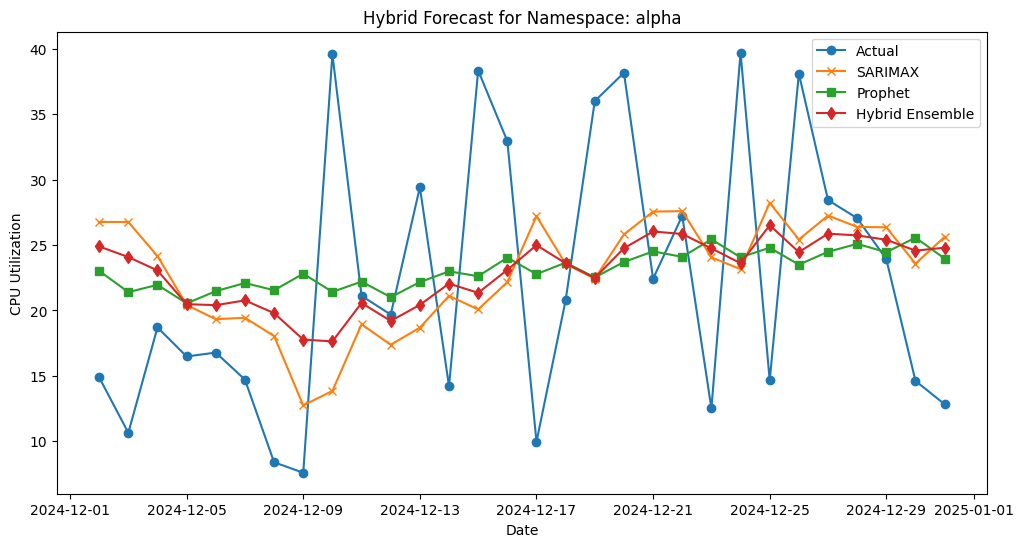

Processing namespace: beta
SARIMAX selected order: (0, 0, 0) seasonal order: (0, 0, 0, 7)


01:21:38 - cmdstanpy - INFO - Chain [1] start processing
01:21:38 - cmdstanpy - INFO - Chain [1] done processing


Namespace: beta -> MAE: 8.1181, MAPE: 43.51%


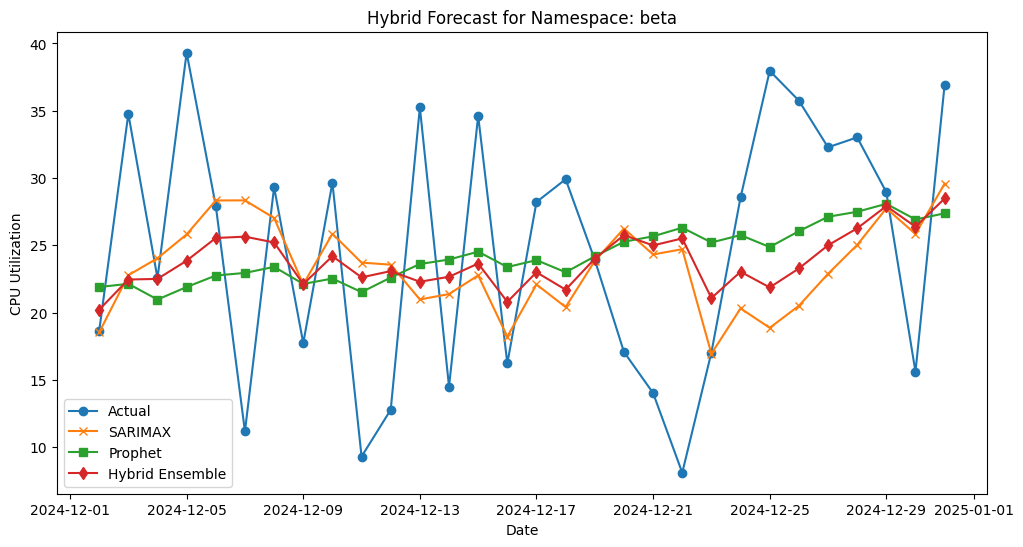

Processing namespace: gamma
SARIMAX selected order: (0, 0, 0) seasonal order: (0, 0, 0, 7)


01:21:44 - cmdstanpy - INFO - Chain [1] start processing
01:21:44 - cmdstanpy - INFO - Chain [1] done processing


Namespace: gamma -> MAE: 8.1317, MAPE: 46.31%


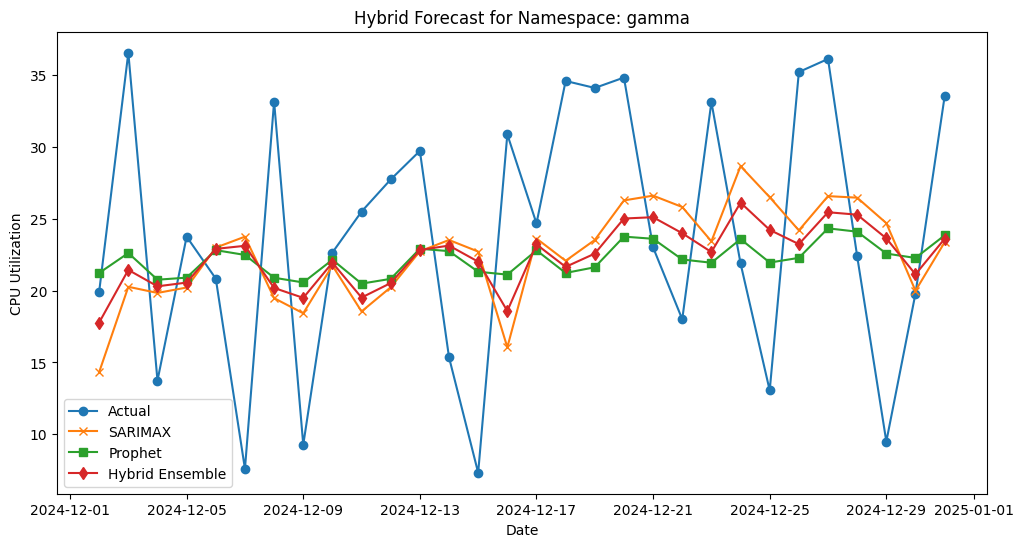


Summary of Forecast Performance:
Namespace: alpha -> MAE: 8.6917, MAPE: 49.67%
Namespace: beta -> MAE: 8.1181, MAPE: 43.51%
Namespace: gamma -> MAE: 8.1317, MAPE: 46.31%


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For SARIMAX tuning
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For Prophet forecasting
from prophet import Prophet

# For evaluation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# ------------------------------
# 1. FEATURE ENGINEERING FUNCTIONS
# ------------------------------

def prepare_sarimax_data(df):
    """
    Prepare target series and exogenous features for SARIMAX.
    Creates:
      - lag1: previous day's cpu_used.
      - rolling_mean_7: 7-day rolling average (shifted by 1).
      - Day-of-week dummy variables.
    Finally, ensure exogenous data is converted to float.
    """
    df_copy = df.copy().sort_index()
    df_copy['lag1'] = df_copy['cpu_used'].shift(1)
    df_copy['rolling_mean_7'] = df_copy['cpu_used'].rolling(window=7).mean().shift(1)
    # Create day-of-week values from the index and one-hot encode them:
    df_copy['dow'] = df_copy.index.dayofweek
    dow_dummies = pd.get_dummies(df_copy['dow'], prefix='dow', drop_first=True).astype(np.float64)
    exog = pd.concat([df_copy[['lag1', 'rolling_mean_7']], dow_dummies], axis=1)
    df_clean = df_copy.dropna()
    y = df_clean['cpu_used'].astype(np.float64)
    exog = exog.loc[df_clean.index].astype(np.float64)
    return y, exog

def prepare_prophet_data(df):
    """
    Prepare a DataFrame for Prophet with extra regressors.
    Features include:
      - ds: date column.
      - y: cpu_used.
      - lag1, rolling_mean_7.
      - day_sin and day_cos representing day-of-week cyclicality.
    Ensure all extra regressor columns are numeric.
    """
    df_copy = df.copy().sort_index()
    df_copy['ds'] = df_copy.index
    df_copy['y'] = df_copy['cpu_used'].astype(np.float64)
    df_copy['lag1'] = df_copy['cpu_used'].shift(1).astype(np.float64)
    df_copy['rolling_mean_7'] = df_copy['cpu_used'].rolling(window=7).mean().shift(1).astype(np.float64)
    df_copy['dow'] = df_copy['ds'].dt.dayofweek
    df_copy['day_sin'] = np.sin(2 * np.pi * df_copy['dow'] / 7).astype(np.float64)
    df_copy['day_cos'] = np.cos(2 * np.pi * df_copy['dow'] / 7).astype(np.float64)
    df_prophet = df_copy[['ds', 'y', 'lag1', 'rolling_mean_7', 'day_sin', 'day_cos']].dropna().reset_index(drop=True)
    return df_prophet

def create_future_prophet_df(last_date, forecast_horizon, last_lag, last_rolling_mean):
    """
    Create a future DataFrame for Prophet.
    For extra regressors 'lag1' and 'rolling_mean_7', we assign the last observed value (naively).
    Cyclical features for day-of-week are computed based on the future dates.
    """
    future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
    future_df = pd.DataFrame({'ds': future_dates})
    future_df['lag1'] = float(last_lag)
    future_df['rolling_mean_7'] = float(last_rolling_mean)
    future_df['day_sin'] = np.sin(2 * np.pi * future_df['ds'].dt.dayofweek / 7).astype(np.float64)
    future_df['day_cos'] = np.cos(2 * np.pi * future_df['ds'].dt.dayofweek / 7).astype(np.float64)
    return future_df

# ------------------------------
# 2. SARIMAX MODEL FUNCTIONS
# ------------------------------

def train_forecast_sarimax(train_y, train_exog, forecast_exog):
    """
    Use auto_arima to select SARIMAX orders (considering seasonal period=7)
    with exogenous regressors. Fit the model on training data and forecast.
    """
    model_auto = pm.auto_arima(train_y, exogenous=train_exog, seasonal=True, m=7, 
                                 stepwise=True, suppress_warnings=True, error_action='ignore')
    order = model_auto.order
    seasonal_order = model_auto.seasonal_order
    print("SARIMAX selected order:", order, "seasonal order:", seasonal_order)
    
    sarimax_model = SARIMAX(train_y, exog=train_exog, order=order, 
                            seasonal_order=seasonal_order, 
                            enforce_stationarity=False, enforce_invertibility=False)
    sarimax_fit = sarimax_model.fit(disp=False)
    forecast_obj = sarimax_fit.get_forecast(steps=len(forecast_exog), exog=forecast_exog)
    forecast_series = forecast_obj.predicted_mean
    forecast_series.index = forecast_exog.index
    return forecast_series, sarimax_fit, order, seasonal_order

# ------------------------------
# 3. PROPHET MODEL FUNCTIONS
# ------------------------------

def train_forecast_prophet(prophet_train_df, future_df, changepoint_prior_scale=0.1, seasonality_prior_scale=10):
    """
    Train a Prophet model with extra regressors.
    Returns forecast (Series) and the fitted Prophet model.
    """
    model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True,
                    changepoint_prior_scale=changepoint_prior_scale,
                    seasonality_prior_scale=seasonality_prior_scale)
    extra_regs = ['lag1', 'rolling_mean_7', 'day_sin', 'day_cos']
    for reg in extra_regs:
        model.add_regressor(reg)
    model.fit(prophet_train_df)
    
    future = future_df.copy()
    forecast = model.predict(future)
    forecast_series = forecast['yhat']
    forecast_series.index = future['ds']
    return forecast_series, model

# ------------------------------
# 4. ENSEMBLE FUNCTION
# ------------------------------

def combine_ensemble(forecast_sarimax, forecast_prophet, weight_sarimax=0.5, weight_prophet=0.5):
    """
    Combine SARIMAX and Prophet forecasts via weighted average.
    """
    combined = weight_sarimax * forecast_sarimax + weight_prophet * forecast_prophet
    return combined

# ------------------------------
# 5. EVALUATION FUNCTION
# ------------------------------

def evaluate_forecasts(actual, forecast):
    """
    Compute MAE and MAPE between actual values and forecast.
    """
    mae = mean_absolute_error(actual, forecast)
    mape = mean_absolute_percentage_error(actual, forecast) * 100
    return mae, mape

# ------------------------------
# 6. FULL HYBRID PIPELINE PER NAMESPACE
# ------------------------------

def run_hybrid_ns(df_ns, forecast_horizon=30):
    """
    For the given namespace, split the data into training and test sets,
    prepare SARIMAX and Prophet data, train both models, combine forecasts,
    and evaluate the performance (MAE and MAPE).
    """
    df_ns = df_ns.sort_index()
    
    # Prepare SARIMAX data
    y, exog = prepare_sarimax_data(df_ns)
    # Prepare Prophet data
    prophet_df = prepare_prophet_data(df_ns)
    
    # Split into training and test sets (last forecast_horizon days as test)
    train_y = y.iloc[:-forecast_horizon]
    test_y = y.iloc[-forecast_horizon:]
    train_exog = exog.iloc[:-forecast_horizon]
    test_exog = exog.iloc[-forecast_horizon:]
    
    prophet_train = prophet_df.iloc[:-forecast_horizon]
    prophet_test = prophet_df.iloc[-forecast_horizon:]
    
    # Prepare Prophet's future DataFrame using last observed lag1 and rolling_mean
    last_lag = prophet_train['lag1'].iloc[-1]
    last_rolling = prophet_train['rolling_mean_7'].iloc[-1]
    last_date = prophet_train['ds'].iloc[-1]
    future_prophet = create_future_prophet_df(last_date, forecast_horizon, last_lag, last_rolling)
    
    # Train RF models and produce forecasts:
    forecast_sarimax, sarimax_fit, order, seasonal_order = train_forecast_sarimax(train_y, train_exog, test_exog)
    forecast_prophet, prophet_model = train_forecast_prophet(prophet_train, future_prophet,
                                                             changepoint_prior_scale=0.1,
                                                             seasonality_prior_scale=10)
    
    # Ensemble both forecasts (equal weighting, for instance)
    combined_forecast = combine_ensemble(forecast_sarimax, forecast_prophet, 0.5, 0.5)
    
    # Evaluate the ensemble forecast on the test set
    mae, mape = evaluate_forecasts(test_y, combined_forecast)
    
    return {
         "test_y": test_y,
         "forecast_sarimax": forecast_sarimax,
         "forecast_prophet": forecast_prophet,
         "combined_forecast": combined_forecast,
         "mae": mae,
         "mape": mape,
         "sarimax_fit": sarimax_fit,
         "sarimax_order": order,
         "sarimax_seasonal_order": seasonal_order,
         "prophet_model": prophet_model,
         "prophet_train": prophet_train,
         "exog": exog,
         "y": y
    }

# ------------------------------
# 7. EXECUTION FOR EACH NAMESPACE
# ------------------------------

if __name__ == '__main__':
    # Read CSV (ensure date is parsed and set as index)
    df = pd.read_csv("../data/cpu_usage_test.csv", parse_dates=["date"])
    df.set_index("date", inplace=True)
    
    results = {}
    
    for ns in df["namespace"].unique():
        print("==========================================")
        print(f"Processing namespace: {ns}")
        df_ns = df[df["namespace"] == ns]
        
        try:
            res = run_hybrid_ns(df_ns, forecast_horizon=30)
        except Exception as e:
            print(f"Error processing namespace {ns}: {e}")
            continue
        
        print(f"Namespace: {ns} -> MAE: {res['mae']:.4f}, MAPE: {res['mape']:.2f}%")
        results[ns] = res
        
        # Plot results
        plt.figure(figsize=(12,6))
        plt.plot(res['test_y'].index, res['test_y'], label="Actual", marker="o")
        plt.plot(res['forecast_sarimax'].index, res['forecast_sarimax'], label="SARIMAX", marker="x")
        plt.plot(res['forecast_prophet'].index, res['forecast_prophet'], label="Prophet", marker="s")
        plt.plot(res['combined_forecast'].index, res['combined_forecast'], label="Hybrid Ensemble", marker="d")
        plt.title(f"Hybrid Forecast for Namespace: {ns}")
        plt.xlabel("Date")
        plt.ylabel("CPU Utilization")
        plt.legend()
        plt.show()
    
    # Summary Report
    print("\nSummary of Forecast Performance:")
    for ns, res in results.items():
        print(f"Namespace: {ns} -> MAE: {res['mae']:.4f}, MAPE: {res['mape']:.2f}%")